# Part two: LGBM, Random Forest and Neural Network - after dummy and hash-encoding


- after LGBM from the previous notebook, the new models will require us to get rid of the null values and to encode all the categorical features
- in this notebook we will do that, re-run the LGBM to see if encoding changes results, and then we will proceed to run Random Forest and deep learning models

<a id = 'Content'><a/>
### Contents:
- [1.0 Functions](#1.0)
- [2.0 Null values](#2.0)
- [3.0 Encoding](#3.0)   
- [4.0 Light GBM with dummy- and hash-encoding](#4.0)
    - [4.1 light gbm 2 (encoded version)](#4.1)
    - [4.2 light gbm w pos weights (encoded version)](#4.2)
    - [4.3 same as 4.1 with pos weights](#4.3)
- [5.0 Random Forest](#5.0)
- [6.0 Neural network](#6.0)
    - [6.1 preprocessing](#6.1)
    - [6.2 neural network model 1](#6.2)
    - [6.3 neural network model 2](#6.3)    
- [7.0 Conclusions](#7.0)

In [1]:
# !pip install category_encoders

In [281]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import re


import gc
import random
import datetime
import decimal
import time
import joblib as jb

import lightgbm as lgb
from category_encoders import HashingEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import  plot_confusion_matrix, precision_score, PrecisionRecallDisplay, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import Precision, Recall, AUC

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000

plt.style.use('fivethirtyeight')

<a id = '1.0'><a/>
### 1.0 Functions
* [Back To Top](#Content)

In [3]:
def display_scores(name, gsearch, xtrain, xtest, ytrain, ytest):
    """ the function takes a fitted gridsearchcv as the arguement and
    displays scores
    """
    print('='*30)
    print(f"\033[1m {name} \033[0m".center(38, "="))
    print('='*30)
    print('\nScores:')
    print('-'*30, '\n')
    print('train score:', round(gsearch.score(xtrain, ytrain),2))
    print('test score:', round(gsearch.score(xtest, ytest),2))
    print('cross-validated score:', round(gsearch.best_score_,2))
    print('')
    print(" Best Parameters:")
    print('-'*30, '\n')
    for key, value in gsearch.best_params_.items():
        print(key,':', value)

In [4]:
def plot_cmatrix(ytest, predict):
    """ plot notFraud/isFraud confusion matrix and recall/accuracy stats,
    renamed, as there are no real 'positive' or 'negative' outcome
    """
    cm = pd.DataFrame(confusion_matrix(ytest, predict),
                 index=['notFraud', 'isFraud'],
                 columns=['Predicted notFraud', 'Predicted isFraud'])
    tn, fp, fn, tp = confusion_matrix(ytest, predict).ravel()
    
    print('\n\n***Confusion Matrix***\n')
    display(cm)
    print('\nScores:')
    print('-'*30, '\n')
    print('Fraud recall:  ', round(tp/(tp+fn),2))
    print('Fraud precision:', round(tp/(tp+fp),2))

In [5]:
def reduce_mem_usage(df):
    """ downcast column data types to reduce memory usage      
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    temp = df.columns.to_list()
    temp.remove('TransactionAmt')
    for col in temp:
        col_type = df[col].dtype
#         if col = ''
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
        

    end_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    print(f'Memory usage of dataframe is {start_mem:.2f} MB --> {end_mem:.2f} MB (Decreased by {100*(start_mem-end_mem)/start_mem:.1f}%)')
    
    del temp
    gc.collect()
    return df

In [6]:
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True

In [7]:
train = pd.read_csv('../datasets/train_4lgb_cdr.csv', parse_dates=['DT'])
test = pd.read_csv('../datasets/test_4lgb_cdr.csv', parse_dates=['DT'])

In [11]:
# copy and past from notebook1 output cell
cat_col = ['ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2','P_emaildomain',
 'R_emaildomain','M4','id_13','id_14','id_15','id_16','id_17','id_19','id_20','id_28','id_29','id_30','id_31','id_32',
 'id_33','id_34','id_35','id_37','id_38','DeviceType','DeviceInfo','DT_M','DT_W','hour','dow',
 'day','addr1_card1','weekday_hour','id_12','M2','M3','M5','M6','M7','M8','M9']

In [12]:
train.drop('DT', axis=1, inplace=True)
test.drop('DT', axis=1, inplace=True)

In [13]:
for col in train.columns:
    if col in cat_col:
        train[col] = train[col].fillna('unknown')
        test[col] = test[col].fillna('unknown')

In [14]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 419.01 MB
Memory usage of dataframe is 419.01 MB --> 94.44 MB (Decreased by 77.5%)
Memory usage of dataframe is 355.65 MB
Memory usage of dataframe is 355.65 MB --> 81.71 MB (Decreased by 77.0%)


<a id = '2.0'><a/>
### 2.0 Null values
* [Back To Top](#Content)

In [ ]:
train.isnull().sum()

In [16]:
# impute D columns (not DT or Device) with their mean
for col in train.columns:
    if col[0]=='D' and col[1] not in['T', 'e']:
        train[col].fillna(train[col].astype(np.float32).mean(), inplace=True)
        test[col].fillna(test[col].astype(np.float32).mean(), inplace=True)


In [18]:
train['dist1'].dtype

dtype('float16')

In [19]:
# impute numberical dist1 column with its mean
train['dist1'].fillna(train['dist1'].astype(np.float32).mean(), inplace=True)
test['dist1'].fillna(test['dist1'].astype(np.float32).mean(), inplace=True)

In [20]:
# columns id1,2,5 and 6 have many nulls. drop them.
train.drop(columns=['id_01', 'id_02', 'id_05', 'id_06'], inplace=True)
test.drop(columns=['id_01', 'id_02', 'id_05', 'id_06'], inplace=True)

In [21]:
train.isnull().sum().sum()

0

In [28]:
test.isnull().sum().sum()

0

In [24]:
lst = [f'C{i}' for i in range(1,15)]
lst.remove('C3')
for col in lst:
    test[col].fillna(test[col].astype(np.float32).mean(), inplace=True)    

In [33]:
test.drop(['DT_M'], axis=1, inplace=True)
train.drop(['DT_M'], axis=1, inplace=True)

cat_col.remove('DT_M')

<a id = '3.0'><a/>
### 3.0 Encoding
* [Back To Top](#Content)

In [36]:
encode = []
dummy = []
for col in cat_col:
    if train[col].nunique()>7:
        encode.append(col)
    else:
        dummy.append(col)

In [37]:
dummy

['ProductCD',
 'card4',
 'card6',
 'M4',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_32',
 'id_34',
 'id_35',
 'id_37',
 'id_38',
 'DeviceType',
 'dow',
 'id_12',
 'M2',
 'M3',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [38]:
train = pd.get_dummies(train, columns=dummy, drop_first=True)
test = pd.get_dummies(test, columns=dummy, drop_first=True)

In [50]:
train.shape, test.shape

((590540, 128), (506691, 127))

In [49]:
set(train.columns)-set(test.columns),set(test.columns)-set(train.columns)

({'isFraud'}, set())

In [48]:
test['card6_debit or credit'] = 0
test['id_34_match_status:0'] = 0
test['id_34_match_status:1'] = 0

train['id_32_48.0'] = 0

In [51]:
encode

['card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'P_emaildomain',
 'R_emaildomain',
 'id_13',
 'id_14',
 'id_17',
 'id_19',
 'id_20',
 'id_30',
 'id_31',
 'id_33',
 'DeviceInfo',
 'DT_W',
 'hour',
 'day',
 'addr1_card1',
 'weekday_hour']

In [ ]:
# train.to_csv('../datasets/train_enc2.csv', index=False)
# test.to_csv('../datasets/test_enc2.csv', index=False)

In [52]:
X = train.sort_values('TransactionDT').drop(
    ['isFraud', 'DT_D', 'TransactionDT', 'TransactionID'], axis=1)
X_kaggletest = test.sort_values('TransactionDT').drop(
    ['DT_D', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

In [53]:
he = HashingEncoder(cols=encode).fit(X, y)

In [54]:
X = he.transform(X)
test_enc = he.transform(X_kaggletest)

In [60]:
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_enc = test_enc.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [61]:
scoring_table=[]
scoring_table_load=[]
result_dict={}

<a id = '4.0'><a/>
### 4.0 light gbm w dummy- and hash-encoding
* [Back To Top](#Content)

<a id = '4.1'><a/>
#### 4.1 light gbm 2 (encoded version)
* [Back To Top](#Content)

In [62]:
n_fold = 5
folds = KFold(n_splits=n_fold)

params = {'num_leaves': 128, 
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.02, #0.03
          "boosting_type": "gbdt",
          "subsample_freq": 2, #3
          "subsample": 0.8, #0.9
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.2, #0.3
          'colsample_bytree': 0.8, #0.9
          #'categorical_feature': cat_cols
         }

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False,  random_state=42)

In [ ]:
columns = X.columns 
n_splits = folds.n_splits 
X_test = X_test[columns]
    

    
# out-of-fold predictions on train data
oof = np.zeros((len(X), 1))

# averaged predictions on test data
prediction = np.zeros((len(X_test), 1))
        
   # list of scores on folds
scores = []
feature_importance = pd.DataFrame()
    
# split and train on folds
for fold_n, (foldtrain_index, valid_index) in enumerate(folds.split(X_train)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
        
    X_foldtrain, X_valid = X[columns].iloc[foldtrain_index], X[columns].iloc[valid_index]
    y_foldtrain, y_valid = y.iloc[foldtrain_index], y.iloc[valid_index]
            
    model_lgb_enc = lgb.LGBMClassifier(**params, n_estimators=300, n_jobs = -1)
    model_lgb_enc.fit(X_foldtrain, y_foldtrain, 
            eval_set=[(X_foldtrain, y_foldtrain), (X_valid,
                                                   y_valid)], eval_metric=eval_auc,
            early_stopping_rounds=200)
            
    y_pred_valid = model_lgb_enc.predict_proba(X_valid)[:, 1]
    y_pred = model_lgb_enc.predict_proba(X_test,
                                         num_iteration=model_lgb_enc.best_iteration_)[:, 1]
            
             
    oof[valid_index] = y_pred_valid.reshape(-1, 1)
    scores.append(roc_auc_score(y_valid, y_pred_valid))
            
    prediction += y_pred.reshape(-1, 1)

              
        
        
    # feature importance
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = model_lgb_enc.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
       

CV mean score: 0.9243, std: 0.0108.


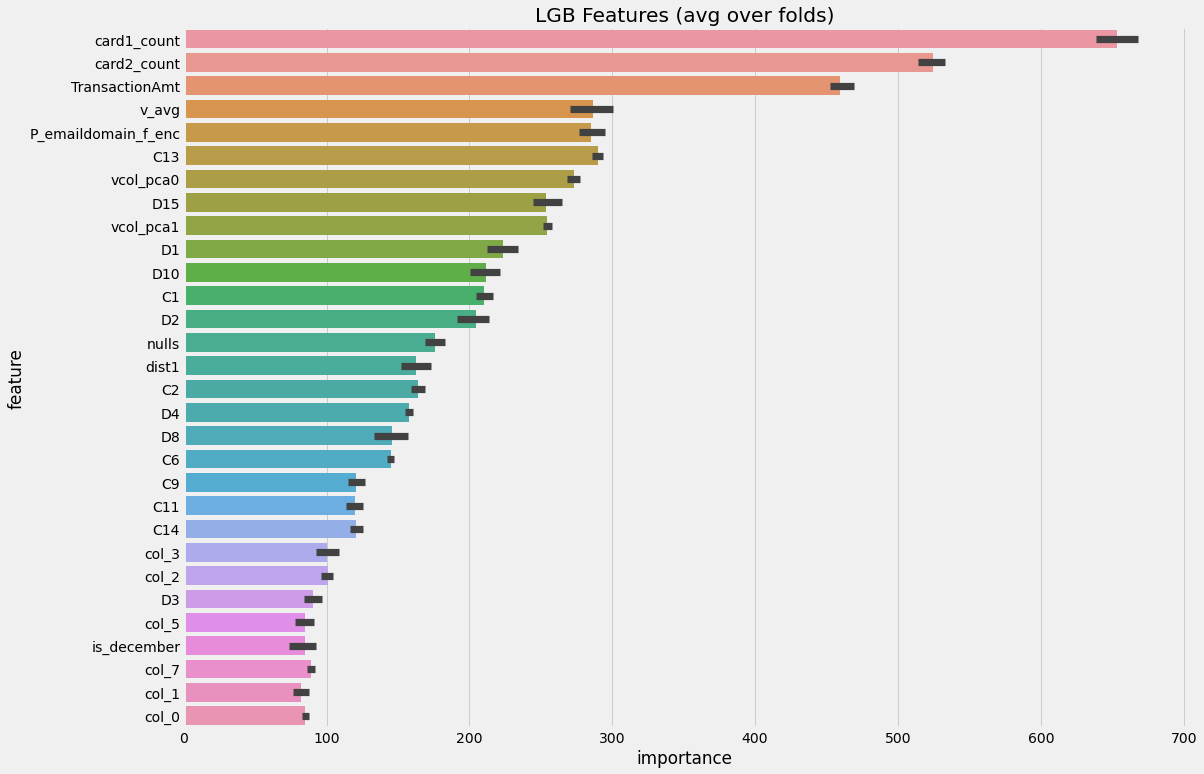

In [69]:
prediction /= n_splits
    
print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    
result_dict['oof_e1'] = oof
result_dict['prediction_e1'] = prediction
result_dict['scores_e1'] = scores
    


feature_importance["importance"] /= n_splits
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                                               by="importance", ascending=False)[:30].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(
                                                            by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');
            
result_dict['feature_importance_e1'] = feature_importance
result_dict['top_columns_e1'] = cols

In [70]:
prediction_label = prediction.round()
print()
print(classification_report(y_test, prediction_label))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99    284501
           1       0.81      0.32      0.46     10769

    accuracy                           0.97    295270
   macro avg       0.89      0.66      0.72    295270
weighted avg       0.97      0.97      0.97    295270



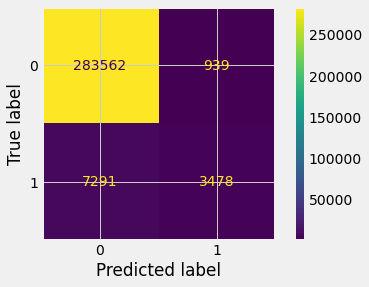

In [72]:
plot_confusion_matrix(model_lgb_enc, X_test, y_test);

In [73]:
model_lgb_enc.get_params

<bound method LGBMModel.get_params of LGBMClassifier(bagging_seed=11, colsample_bytree=0.8, learning_rate=0.02,
               max_depth=13, metric='auc', min_child_samples=79,
               n_estimators=300, num_leaves=128, objective='binary',
               reg_alpha=0.3, reg_lambda=0.2, subsample=0.8, subsample_freq=2,
               verbosity=-1)>

In [74]:
# filename_model_lgb_enc = '../Models/model_ljg_enc.sav'
# test_loading1 = jb.load(filename_model_lgb_enc)

In [80]:
table = {'Model': 'LGBM_enc1'}
table['CV mean ROC-AUC'] = np.mean(scores)
table['ROC-AUC-train'] = roc_auc_score(y_train, oof[:len(X_train)])
table['ROC-AUC-test'] = roc_auc_score(y_test, prediction)
table['Precision'] = precision_score(y_test, prediction_label)
table['Recall'] = recall_score(y_test, prediction_label)

scoring_table.append(table)

In [ ]:
# table_load = {'Model': 'LGBM1'}
# table_load['ROC-AUC-train'] = roc_auc_score(y_train, test_loading.predict_proba(X_train)[:,1])
# table_load['ROC-AUC-test'] = roc_auc_score(y_test, test_loading.predict_proba(X_test)[:,1])
# table_load['Precision'] = precision_score(y_test, test_loading.predict(X_test))
# table_load['Recall'] = recall_score(y_test, test_loading.predict(X_test))

# scoring_table_load.append(table_load)

In [81]:
table

{'Model': 'LGBM_enc1',
 'CV mean ROC-AUC': 0.9242801082771159,
 'ROC-AUC-train': 0.9254746112929142,
 'ROC-AUC-test': 0.8988196375723794,
 'Precision': 0.8115737473535639,
 'Recall': 0.32036400780016716}

In [ ]:
# print('ROC-AUC on test data:', round(roc_auc_score(y_test, prediction),4))

In [ ]:
# filename_model_lgb_enc = '../Models/model_lgb_enc.sav'
# jb.dump(model_lgb_enc, filename_model_lgb_enc)

In [ ]:
# prediction_lgb_enc=prediction

<a id = '4.2'><a/>
#### 4.2 same as 4.1 w pos weights
* [Back To Top](#Content)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75,
                                                    shuffle=False,  random_state=42)

In [83]:
params = {'num_leaves': 126,#256
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 15, #13
          'learning_rate': 0.02, #0.03
          "boosting_type": "gbdt",
          "subsample_freq": 2, #3
          "subsample": 0.8, #0.9
          "bagging_seed": 15, #11
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.2, #0.3
#           'reg_lambda': 0.2, #0.3
          'colsample_bytree': 0.8, #0.9,
          'scale_pos_weight': 60 # THIS IS THE KEY ADDITION
         }

In [ ]:
columns = X.columns 
n_splits = folds.n_splits 
X_test = X_test[columns]
    

    
# out-of-fold predictions on train data
oof = np.zeros((len(X), 1))

# averaged predictions on test data
prediction = np.zeros((len(X_test), 1))
        
   # list of scores on folds
scores = []
feature_importance = pd.DataFrame()
    
# split and train on folds
for fold_n, (foldtrain_index, valid_index) in enumerate(folds.split(X_train)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
        
    X_foldtrain, X_valid = X[columns].iloc[foldtrain_index], X[columns].iloc[valid_index]
    y_foldtrain, y_valid = y.iloc[foldtrain_index], y.iloc[valid_index]
            
    model_lgb_enc_W = lgb.LGBMClassifier(**params, n_estimators=400, n_jobs = -1)
    model_lgb_enc_W.fit(X_foldtrain, y_foldtrain, 
            eval_set=[(X_foldtrain, y_foldtrain), (X_valid, y_valid)], eval_metric=eval_auc,
            early_stopping_rounds=200)
            
    y_pred_valid = model_lgb_enc_W.predict_proba(X_valid)[:, 1]
    y_pred = model_lgb_enc_W.predict_proba(X_test, num_iteration=model_lgb_enc_W.best_iteration_)[:, 1]
            
             
    oof[valid_index] = y_pred_valid.reshape(-1, 1)
    scores.append(roc_auc_score(y_valid, y_pred_valid))
            
    prediction += y_pred.reshape(-1, 1)

              
        
        
    # feature importance
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = model_lgb_enc_W.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)


CV mean score: 0.9065, std: 0.0046.


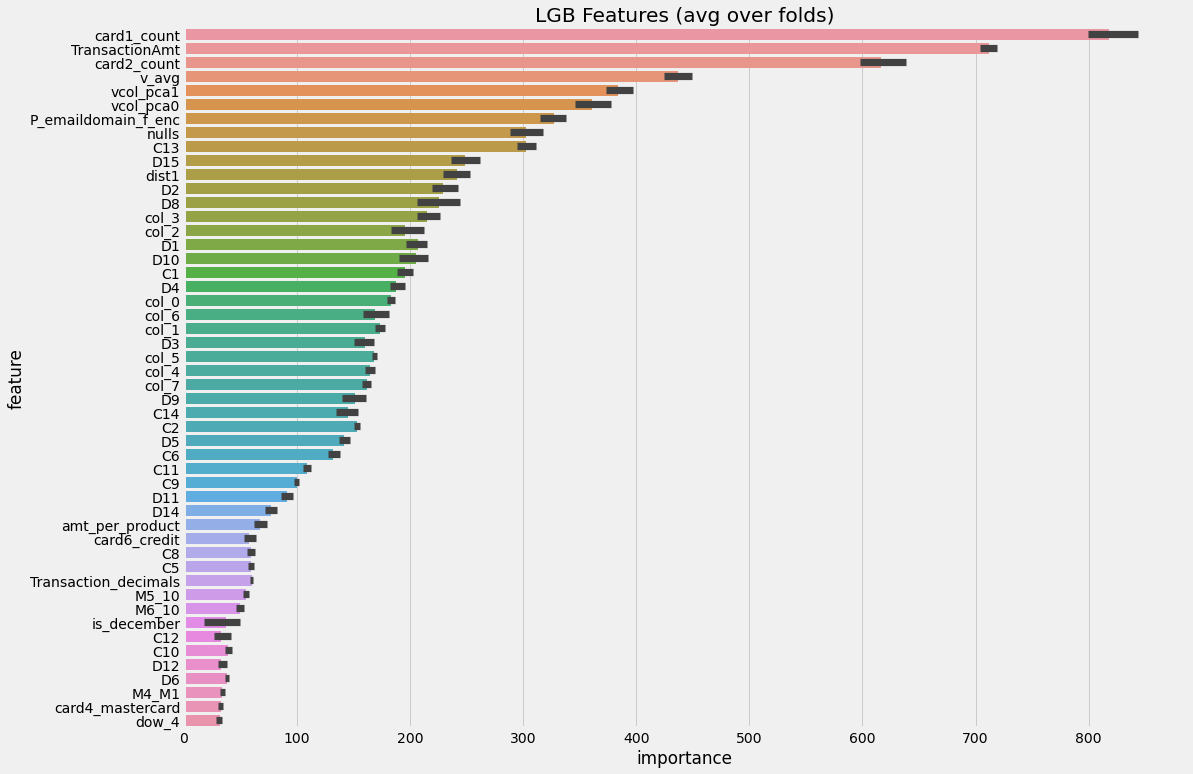

In [89]:
prediction /= n_splits
    
print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    
result_dict['oof_e2'] = oof
result_dict['prediction_e2'] = prediction
result_dict['scores_e2'] = scores
    


feature_importance["importance"] /= n_splits
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                                               by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(
                                                            by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');
            
result_dict['feature_importance_e2'] = feature_importance
result_dict['top_columns_e2'] = cols
        
# return result_dict

In [90]:
prediction_label = prediction.round()
print()
print(classification_report(y_test, prediction_label))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97    426130
           1       0.37      0.51      0.43     16775

    accuracy                           0.95    442905
   macro avg       0.67      0.74      0.70    442905
weighted avg       0.96      0.95      0.95    442905



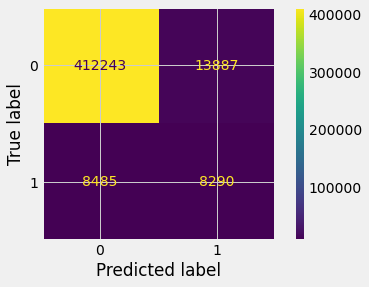

In [91]:
plot_confusion_matrix(model_lgb_enc_W, X_test, y_test);

In [92]:
model_lgb_enc_W.get_params

<bound method LGBMModel.get_params of LGBMClassifier(bagging_seed=15, colsample_bytree=0.8, learning_rate=0.02,
               max_depth=15, metric='auc', min_child_samples=79,
               n_estimators=400, num_leaves=126, objective='binary',
               reg_alpha=0.2, scale_pos_weight=60, subsample=0.8,
               subsample_freq=2, verbosity=-1)>

In [93]:
# filename_model_lgb_enc_W = '../Models/model_lgb_enc_W.sav'
# test_loading2 = jb.load(filename_model_lgb_enc_W)

In [94]:
table = {'Model': 'LGBM_enc2_W'}
table['CV mean ROC-AUC'] = np.mean(scores)
table['ROC-AUC-train'] = roc_auc_score(y_train, oof[:len(X_train)])
table['ROC-AUC-test'] = roc_auc_score(y_test, prediction)
table['Precision'] = precision_score(y_test, prediction_label)
table['Recall'] = recall_score(y_test, prediction_label)

scoring_table.append(table)

In [ ]:
# table_load = {'Model': 'LGBM1'}
# table_load['ROC-AUC-train'] = roc_auc_score(y_train, test_loading.predict_proba(X_train)[:,1])
# table_load['ROC-AUC-test'] = roc_auc_score(y_test, test_loading.predict_proba(X_test)[:,1])
# table_load['Precision'] = precision_score(y_test, test_loading.predict(X_test))
# table_load['Recall'] = recall_score(y_test, test_loading.predict(X_test))

# scoring_table_load.append(table_load)

In [ ]:
# filename_model_lgb_enc_W = '../Models/model_lgb_enc_W.sav'
# jb.dump(model_lgb_enc_W, filename_model_lgb_enc_W)

<a id = '4.3'><a/>
#### 4.3 same as 4.1 w 32-bit hash-encoding
* [Back To Top](#Content)

In [97]:
XXX = train.sort_values('TransactionDT').drop(
    ['isFraud', 'DT_D', 'TransactionDT', 'TransactionID'], axis=1)
# X_kaggletest = test.sort_values('TransactionDT').drop(
#     ['DT_D', 'TransactionDT', 'TransactionID'], axis=1)
# y = train.sort_values('TransactionDT')['isFraud']

In [98]:
he = HashingEncoder(cols=encode, n_components=32).fit(XXX, y)

In [99]:
XXX = he.transform(XXX)

In [100]:
XXX = XXX.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [101]:
n_fold = 5
folds = KFold(n_splits=n_fold)

params = {'num_leaves': 128, 
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.02, #0.03
          "boosting_type": "gbdt",
          "subsample_freq": 2, #3
          "subsample": 0.8, #0.9
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.2, #0.3
          'colsample_bytree': 0.8, #0.9
          #'categorical_feature': cat_cols
         }

In [102]:
X_train, X_test, y_train, y_test = train_test_split(XXX, y, test_size=0.5,
                                                    shuffle=False,  random_state=42)

In [ ]:
columns = XXX.columns 
n_splits = folds.n_splits 
X_test = X_test[columns]
    

    
# out-of-fold predictions on train data
oof = np.zeros((len(XXX), 1))

# averaged predictions on test data
prediction = np.zeros((len(X_test), 1))
        
   # list of scores on folds
scores = []
feature_importance = pd.DataFrame()
    
# split and train on folds
for fold_n, (foldtrain_index, valid_index) in enumerate(folds.split(X_train)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
        
    X_foldtrain, X_valid = XXX[columns].iloc[foldtrain_index], XXX[columns].iloc[valid_index]
    y_foldtrain, y_valid = y.iloc[foldtrain_index], y.iloc[valid_index]
            
    model_lgb_enc32 = lgb.LGBMClassifier(**params, n_estimators=300, n_jobs = -1)
    model_lgb_enc32.fit(X_foldtrain, y_foldtrain, 
            eval_set=[(X_foldtrain, y_foldtrain), (X_valid, y_valid)], eval_metric=eval_auc,
            early_stopping_rounds=200)
            
    y_pred_valid = model_lgb_enc32.predict_proba(X_valid)[:, 1]
    y_pred = model_lgb_enc32.predict_proba(X_test, num_iteration=model_lgb_enc32.best_iteration_)[:, 1]
            
             
    oof[valid_index] = y_pred_valid.reshape(-1, 1)
    scores.append(roc_auc_score(y_valid, y_pred_valid))
            
    prediction += y_pred.reshape(-1, 1)

              
        
        
    # feature importance
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = model_lgb_enc32.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)



CV mean score: 0.9239, std: 0.0110.


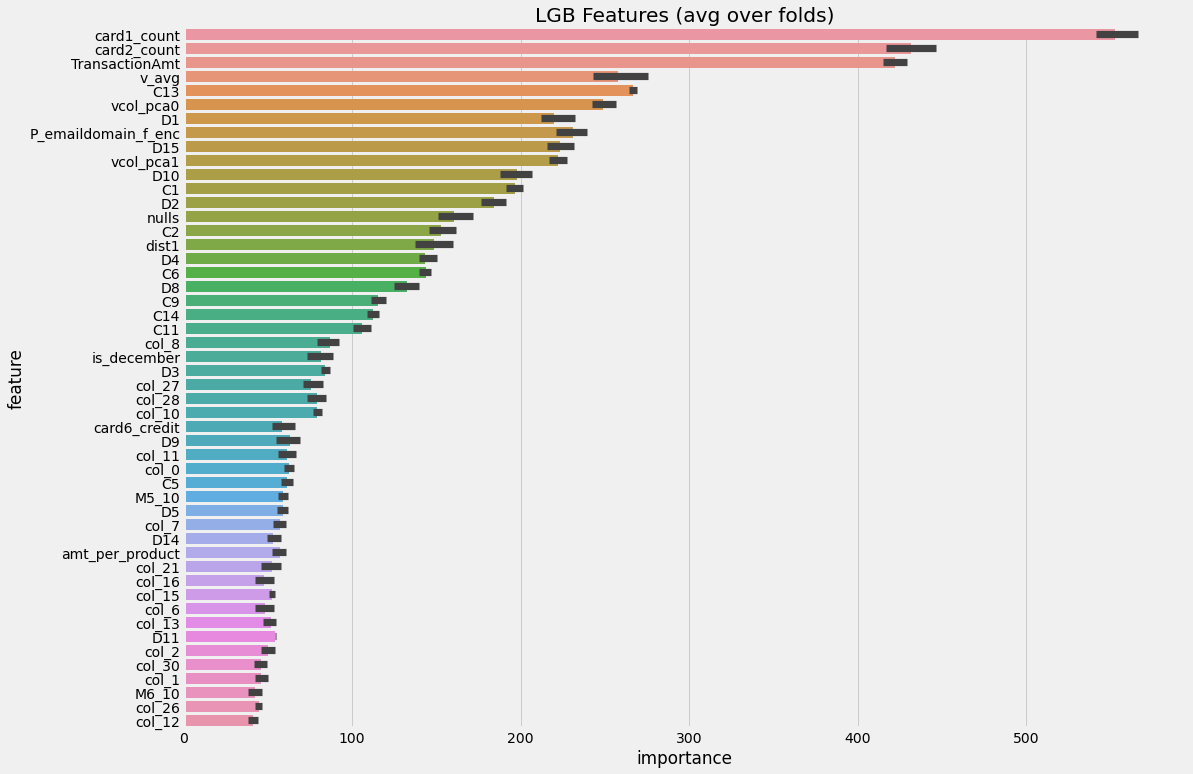

In [104]:
prediction /= n_splits
    
print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    
result_dict['oof_e3'] = oof
result_dict['prediction_e3'] = prediction
result_dict['scores_e3'] = scores
    


feature_importance["importance"] /= n_splits
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                                               by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(
                                                            by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');
            
result_dict['feature_importance_e3'] = feature_importance
result_dict['top_columns_e3'] = cols

In [105]:
prediction_label = prediction.round()
print()
print(classification_report(y_test, prediction_label))



              precision    recall  f1-score   support

           0       0.97      1.00      0.99    284501
           1       0.82      0.32      0.46     10769

    accuracy                           0.97    295270
   macro avg       0.90      0.66      0.72    295270
weighted avg       0.97      0.97      0.97    295270



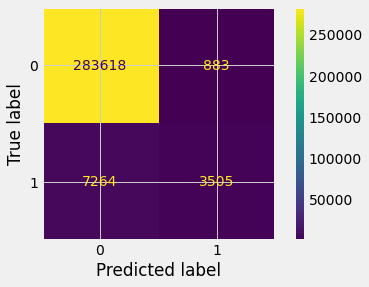

In [106]:
plot_confusion_matrix(model_lgb_enc32, X_test, y_test)

In [107]:
model_lgb_enc32.get_params

<bound method LGBMModel.get_params of LGBMClassifier(bagging_seed=11, colsample_bytree=0.8, learning_rate=0.02,
               max_depth=13, metric='auc', min_child_samples=79,
               n_estimators=300, num_leaves=128, objective='binary',
               reg_alpha=0.3, reg_lambda=0.2, subsample=0.8, subsample_freq=2,
               verbosity=-1)>

In [108]:
# filename_model_lgb_enc32 = '../Models/model_lgb_enc32.sav'
# test_loading3 = jb.load(filename_model_lgb_enc32)

In [109]:
table = {'Model': 'LGBM_enc32'}
table['CV mean ROC-AUC'] = np.mean(scores)
table['ROC-AUC-train'] = roc_auc_score(y_train, oof[:len(X_train)])
table['ROC-AUC-test'] = roc_auc_score(y_test, prediction)
table['Precision'] = precision_score(y_test, prediction_label)
table['Recall'] = recall_score(y_test, prediction_label)

scoring_table.append(table)

In [115]:
table

{'Model': 'LGBM_enc32',
 'CV mean ROC-AUC': 0.9239109462254117,
 'ROC-AUC-train': 0.925275221536445,
 'ROC-AUC-test': 0.9001890538059367,
 'Precision': 0.8185053380782918,
 'Recall': 0.32036400780016716}

In [110]:
# table_load = {'Model': 'LGBM1'}
# table_load['ROC-AUC-train'] = roc_auc_score(y_train, test_loading.predict_proba(X_train)[:,1])
# table_load['ROC-AUC-test'] = roc_auc_score(y_test, test_loading.predict_proba(X_test)[:,1])
# table_load['Precision'] = precision_score(y_test, test_loading.predict(X_test))
# table_load['Recall'] = recall_score(y_test, test_loading.predict(X_test))

# scoring_table_load.append(table_load)

In [111]:
# print('ROC-AUC on test data:', round(roc_auc_score(y_test, prediction),4))

In [112]:
# filename_model_lgb_enc32 = '../Models/model_lgb_enc32.sav'
# jb.dump(model_lgb_enc32, filename_model_lgb_enc32)

In [113]:
# prediction_lgb_enc32=prediction

In [114]:
# display_scores('Light GBM 32bit_encode', model_lgb_enc32, X_train, X_test, y_train, y_test)

<a id = '5.0'><a/>
### 5.0 Random Forest
* [Back To Top](#Content)

In [116]:
X.shape

(590540, 110)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    shuffle=False,  random_state=42)

In [159]:
param_rf1 = {
    'criterion': ['gini'],
    'ccp_alpha':[0],
    'max_depth': [25],
    'max_features': [8,12],
    'min_samples_split': [100],
    'n_estimators': [300]
}

In [160]:
# rf1 = RandomForestClassifier(random_state=42)

In [161]:
# gs_rf1 = GridSearchCV(estimator = rf1, param_grid = param_rf1, scoring='roc_auc',
#                           cv = 5, n_jobs = -1, verbose = 1000)
# gs_rf1.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0], 'criterion': ['gini'],
                         'max_depth': [25], 'max_features': [8, 12],
                         'min_samples_split': [100], 'n_estimators': [300]},
             scoring='roc_auc', verbose=1000)

In [ ]:
# gs_rf1.best_params_

In [154]:
filename_gs_rf1_be = '../Models/gs_rf1_be.sav'
gs_rf1 = jb.load(filename_gs_rf1_be)

# filename_gs_rf1 = '../Models/gs_rf1.sav'
# jb.dump(gs_rf1.best_estimator_, filename_gs_rf1)

In [156]:
gs_rf1

RandomForestClassifier(ccp_alpha=0, max_depth=25, max_features=10,
                       min_samples_split=50, n_estimators=450, random_state=42)

In [162]:
print(classification_report(y_test, gs_rf1.predict(X_test)),'/n')
print('best params: ', gs_rf1)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    171037
           1       0.84      0.26      0.40      6125

    accuracy                           0.97    177162
   macro avg       0.91      0.63      0.69    177162
weighted avg       0.97      0.97      0.97    177162
 /n
best params:  GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0], 'criterion': ['gini'],
                         'max_depth': [25], 'max_features': [8, 12],
                         'min_samples_split': [100], 'n_estimators': [300]},
             scoring='roc_auc', verbose=1000)


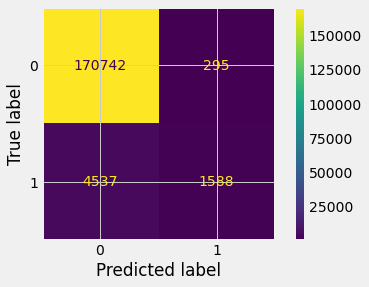

In [163]:
plot_confusion_matrix(gs_rf1, X_test, y_test)

In [164]:
feat_imp = gs_rf1.best_estimator_.feature_importances_

In [165]:
top_features = pd.DataFrame({'feature': X.columns , 'importance': feat_imp}).sort_values(
    ['importance'], ascending=False).iloc[:30,:]

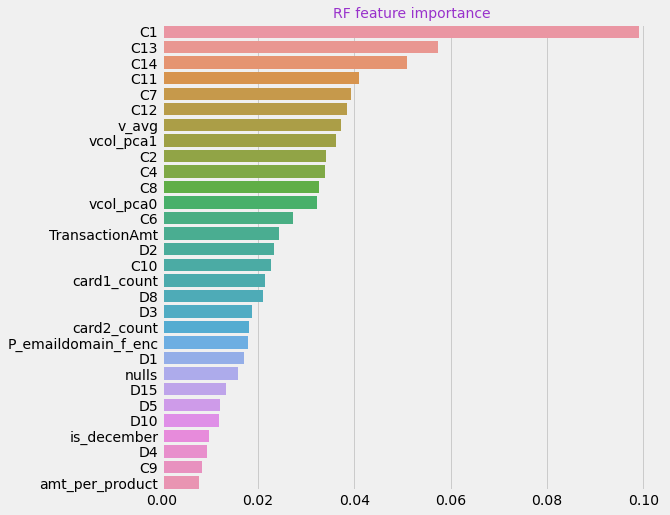

In [166]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=top_features['importance'] , y = top_features['feature'])
plt.title('RF feature importance', fontsize=14, 
            color='Darkorchid')
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [167]:
table = {'Model': 'RF1'}
table['CV mean ROC-AUC'] = gs_rf1.best_score_
table['ROC-AUC-train'] = gs_rf1.score(X_train, y_train)
table['ROC-AUC-test'] = gs_rf1.score(X_test, y_test)
table['Precision'] = precision_score(y_test, gs_rf1.predict(X_test))
table['Recall'] = recall_score(y_test, gs_rf1.predict(X_test))
table

{'Model': 'RF1',
 'CV mean ROC-AUC': 0.8965494117221681,
 'ROC-AUC-train': 0.9763664284217599,
 'ROC-AUC-test': 0.8866158364349617,
 'Precision': 0.8433351035581519,
 'Recall': 0.25926530612244897}

In [171]:
scoring_table.append(table)

In [ ]:
# print('best params: ', gs_rf1.best_params_)
# print('train score: ', gs_rf1.score(X_train, y_train))
# print('test score: ', gs_rf1.score(X_test, y_test))
# print('cross-val score: ', gs_rf1.best_score_)

In [174]:
# filename_gs_rf1 = '../Models/gs_rf1.sav'
# filename_gs_rf1_be = '../Models/gs_rf1_be.sav'
# jb.dump(gs_rf1.best_estimator_, filename_gs_rf1_be)
# jb.dump(gs_rf1, filename_gs_rf1)

['../Models/gs_rf1.sav']

<a id = '6.0'><a/>
### 6.0 Neural nework
* [Back To Top](#Content)

<a id = '6.1'><a/>
#### 6.1 Preprocessing
* [Back To Top](#Content)

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False,  random_state=42)

In [184]:
non_cat = list( set(X_train.columns)-set(cat_col))

In [ ]:
cat_col

In [185]:
non_cat = [col for col in non_cat if col not in ['is_december', 'vcol_pca0', 'vcol_pca1',
                                                'TransactionDT', 'TransactionID', 'DT_D']]

In [186]:
mms = MinMaxScaler()

X_train[non_cat] = mms.fit_transform(X_train[non_cat])
X_test[non_cat] = mms.transform(X_test[non_cat])

In [187]:
pos=y.value_counts(normalize=True)[1]
pos

0.03499000914417313

In [190]:
n_input = X_train.shape [1]

pos = y.value_counts(normalize=True)[1]
initial_bias = np.log([pos/(1-pos)])
output_bias = Constant(initial_bias)


<a id = '6.2'><a/>
### 6.2 Neural network models 1
* [Back To Top](#Content)

In [194]:
n_input = X_train.shape [1]

early_stop = EarlyStopping(monitor='val_prc', patience=10, verbose=1, mode='max')


pos = y.value_counts(normalize=True)[1]
initial_bias = np.log([pos/(1-pos)])
output_bias = Constant(initial_bias)
Metrics = [
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    AUC(name='prc', curve='PR')
]

In [195]:

model_nn = Sequential()
model_nn.add(Dense(70, input_dim=n_input, activation='relu'))
model_nn.add(Dense(40, activation='relu'))
model_nn.add(Dense(20, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))


model_nn.compile(loss='bce', optimizer='adam', metrics=Metrics)



In [ ]:
history = model_nn.fit(X_train, y_train, validation_data=(X_test, y_test),
                      epochs=20, batch_size=None, class_weight={0:2, 1:98}, callbacks=[early_stop], verbose=2)

In [199]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                7770      
                                                                 
 dense_1 (Dense)             (None, 40)                2840      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________


In [200]:
results = model_nn.evaluate(X_test, y_test,  verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5347


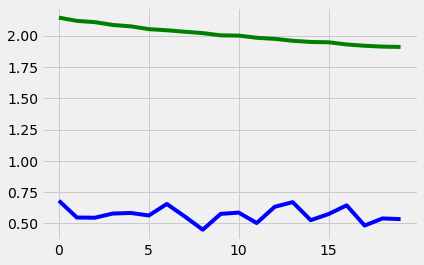

In [204]:
plt.plot(history.epoch, history.history['loss'], c='g');      # green - training loss
plt.plot(history.epoch, history.history['val_loss'], c='b');  # blue - test loss

In [205]:
pred_model_nn = model_nn.predict(X_test)

In [206]:
np.round(pred_model_nn).sum()/len(pred_model_nn)

0.2521556541470519

In [207]:
plot_cmatrix(y_test, np.round(pred_model_nn))



***Confusion Matrix***



,Predicted notFraud,Predicted isFraud
notFraud,217891,66610
isFraud,2925,7844



Scores:
------------------------------ 

Fraud recall:   0.73
Fraud precision: 0.11


In [211]:
roc_auc_score(y_train, model_nn.predict(X_train))

0.8288812292646751

In [212]:
table = {'Model': 'CNN1'}

table['CV mean ROC-AUC'] = 'N/A'
table['ROC-AUC-train'] = roc_auc_score(y_train, model_nn.predict(X_train))
table['ROC-AUC-test'] = roc_auc_score(y_test, model_nn.predict(X_test))
table['Precision'] = precision_score(y_test, np.round(pred_model_nn))
table['Recall'] = recall_score(y_test,np.round(pred_model_nn))
table

{'Model': 'CNN1',
 'CV mean ROC-AUC': 'N/A',
 'ROC-AUC-train': 0.9156116515089099,
 'ROC-AUC-test': 0.8217454628760483,
 'Precision': 0.10535364117441642,
 'Recall': 0.7283870368650757}

In [ ]:
# model_nn.save('../Models/model_nn.sav')
# model_nn_loaded = keras.models.load_model('../Models/model_nn.sav')

In [217]:
scoring_table.append(table)

<a id = '6.3'><a/>
### 6.3 Neural network model 3
* [Back To Top](#Content)

- add learning rate of 0.01 and in tandem, ReduceLROnPlateau callback to reduce the said learning rate by a factor of 0.3 on each 3 epochs with no improvement in validation auc-roc.

In [218]:
#callbacks
early_stop = EarlyStopping(monitor='val_auc', patience=15, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.3,
                              patience=3, min_lr=0.001)


Metrics = [
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    AUC(name='prc', curve='PR')
]

In [219]:
model_nn2 = Sequential()
model_nn2.add(Dense(100, input_dim=n_input, activation='relu'))
model_nn2.add(Dense(50, activation='relu'))
model_nn2.add(Dense(25, activation='relu'))
model_nn2.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))


opt = keras.optimizers.Adam(learning_rate=0.01)
model_nn2.compile(loss='bce', optimizer=opt, metrics=Metrics)

In [ ]:
history_new = model_nn2.fit(X_train, y_train, validation_data=(X_test, y_test),
                      epochs=50, batch_size=None, class_weight={0:3, 1:97}, callbacks=[early_stop, reduce_lr], verbose=2)

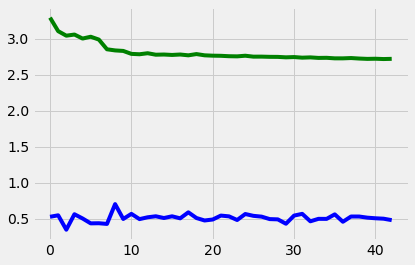

In [221]:
plt.plot(history_new.epoch, history_new.history['loss'], c='g');      # green - training loss
plt.plot(history_new.epoch, history_new.history['val_loss'], c='b');  # blue - test loss

In [222]:
pred_model_nn2 = model_nn2.predict(X_test)

In [223]:
np.round(pred_model_nn2).sum()/len(pred_model_nn)

0.20365089579029363

In [224]:
plot_cmatrix(y_test, np.round(pred_model_nn2))



***Confusion Matrix***



,Predicted notFraud,Predicted isFraud
notFraud,231653,52848
isFraud,3485,7284



Scores:
------------------------------ 

Fraud recall:   0.68
Fraud precision: 0.12


In [225]:
table = {'Model': 'CNN2-rlr'}

table['CV mean ROC-AUC'] = 'N/A'
table['ROC-AUC-train'] = roc_auc_score(y_train, model_nn2.predict(X_train))
table['ROC-AUC-test'] = roc_auc_score(y_test, model_nn2.predict(X_test))
table['Precision'] = precision_score(y_test, np.round(pred_model_nn2))
table['Recall'] = recall_score(y_test,np.round(pred_model_nn2))
table

{'Model': 'CNN2-rlr',
 'CV mean ROC-AUC': 'N/A',
 'ROC-AUC-train': 0.8773237798574737,
 'ROC-AUC-test': 0.8202745229182257,
 'Precision': 0.12113350628617042,
 'Recall': 0.6763859225554834}

In [229]:
scoring_table.append(table)
scoring_table

[{'Model': 'LGBM_enc1',
  'CV mean ROC-AUC': 0.9242801082771159,
  'ROC-AUC-train': 0.9254746112929142,
  'ROC-AUC-test': 0.8988196375723794,
  'Precision': 0.8115737473535639,
  'Recall': 0.32036400780016716},
 {'Model': 'LGBM_enc2_W',
  'CV mean ROC-AUC': 0.9064810343220386,
  'ROC-AUC-train': 0.9041648974402643,
  'ROC-AUC-test': 0.8738520789626306,
  'Precision': 0.36795556505020294,
  'Recall': 0.5133830104321908},
 {'Model': 'LGBM_enc32',
  'CV mean ROC-AUC': 0.9239109462254117,
  'ROC-AUC-train': 0.925275221536445,
  'ROC-AUC-test': 0.9001890538059367,
  'Precision': 0.8185053380782918,
  'Recall': 0.32036400780016716},
 {'Model': 'RF1',
  'CV mean ROC-AUC': 0.8965494117221681,
  'ROC-AUC-train': 0.9763664284217599,
  'ROC-AUC-test': 0.8866158364349617,
  'Precision': 0.8433351035581519,
  'Recall': 0.25926530612244897},
 {'Model': 'CNN2-rlr',
  'CV mean ROC-AUC': 'N/A',
  'ROC-AUC-train': 0.8773237798574737,
  'ROC-AUC-test': 0.8202745229182257,
  'Precision': 0.121133506286170

In [228]:
# table1

{'Model': 'CNN1',
 'CV mean ROC-AUC': 'N/A',
 'ROC-AUC-train': 0.9156116515089099,
 'ROC-AUC-test': 0.8217454628760483,
 'Precision': 0.10535364117441642,
 'Recall': 0.7283870368650757}

In [ ]:
# model_nn2.save('../Models/model_nn2.sav')
# model_nn2_loaded = keras.models.load_model('../Models/model_nn2.sav')

In [230]:
[9,1]+[4,5]

[9, 1, 4, 5]

In [232]:
#copy paste the scoring table from the previous notebook and add it to this one
new_table = [{'Model': 'LGBM1',
  'CV mean ROC-AUC': 0.9237209868128602,
  'ROC-AUC-train': 0.9249212975379344,
  'ROC-AUC-test': 0.8878715164195475,
  'Precision': 0.8689538807649044,
  'Recall': 0.28693472002971493},
 {'Model': 'LGBM2',
  'CV mean ROC-AUC': 0.9138002901461071,
  'ROC-AUC-train': 0.911785761942706,
  'ROC-AUC-test': 0.8718071234245038,
  'Precision': 0.8643410852713178,
  'Recall': 0.2691986256848361},
 {'Model': 'LGBM3-wght',
  'CV mean ROC-AUC': 0.9006955440640529,
  'ROC-AUC-train': 0.8946079476688565,
  'ROC-AUC-test': 0.8962648396644237,
  'Precision': 0.4997057092407298,
  'Recall': 0.49941176470588233}] + scoring_table

In [261]:
models = pd.DataFrame(new_table).replace('N/A', np.nan).round(3)
models

,Model,CV mean ROC-AUC,ROC-AUC-train,ROC-AUC-test,Precision,Recall
0,LGBM1,0.924,0.925,0.888,0.869,0.287
1,LGBM2,0.914,0.912,0.872,0.864,0.269
2,LGBM3-wght,0.901,0.895,0.896,0.500,0.499
3,LGBM_enc1,0.924,0.925,0.899,0.812,0.320
4,LGBM_enc2_W,0.906,0.904,0.874,0.368,0.513
5,LGBM_enc32,0.924,0.925,0.900,0.819,0.320
6,RF1,0.897,0.976,0.887,0.843,0.259
7,CNN2-rlr,NaN,0.877,0.820,0.121,0.676


In [262]:
models.to_csv('../datasets/models_tablefinal.csv', index=False)

In [301]:
def highlight(s, value, column):
    """ the function takes a df, a value and a column and highlights 
    rows in the df where the column cell equals the value
    """
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = (s.loc[column] == value)
    return ['background-color: lightsalmon' if is_max.any() else '' for v in is_max]

In [ ]:
models.style.apply(highlight, value=0.899, column=['ROC-AUC-test'], axis=1)

<a id = '7.0'><a/>
### 7.0 Conclusions
* [Back To Top](#Content)

- As we can see in the table above, many of the models we ran have a similar ROC-AUC score in the range of 0.88-0.90. Of course, when it comes to issues as important at credit card fraud, every percentage point matters, and in a dataset as unbalanced as this one, where only 3.5% of rows are fraud, every little improvement is hard to come by.

- The first 3 models (0, 1, and 2) are run on a dataset without encoded categorical features and without filled-in null values. That was done because the model used was Light GBM which handles nulls and categorical columns internally better than if it had been undertaken by us

- the results of the model 2 (LGBM3-wght) are a fluke. Firstly, it test score is higher than its train score which doesn't make any sense. Secondly, we added weights to counter the unbalanced data which should result in higher recall and lower ROC-AUC, as focusing on positive (fraud) outcome uncovers more of them at the expense of overall test metrics. Instead the ROC-AUC went up, counter-intuitively. Normally we would reshuffle the train and test data to double-check such results, but since chronological data does not get shuffled, we couldn't do that.

- After encoding (models 3 and up) we could run different classifiers (RF, NN) in addition to re-running the LGBM. The results of LGBM are generally better after encoding (dummy and hash) than before. The conclusions we can draw from that are that: splitting key features with low cardinality increased the predictive power of our model, as expected. Moreover, we can conclude that hash encoding,  by 'compacting' many high-cardinality features into only 8 columns managed to preserve predictive power of the model. That is a laudable achievement for our hash-encoder as it gives us a way to model categorical data without exploding the size of our dataset.

- model 5 - LGBM with a 32-bit hash encoding (rather than previously used 8-bit one) did not result in any improvement, despite the additional 24 columns of hashing space. Hence, the model 3 is preferred as it's exactly the same as model 5, but it takes up 24 fewer columns

- model 7, the Keras Neural Network Classifier, while not ideally suited for unbalanced classification, managed to produce a model with the highest recall score of 0.676 - catching more than 2/3 of fraudulent transaction. Industry standard is 50%, so that's quite good. The downside is that the precision is quite low, so many legitimate transactions will get delayed or declined.


**WAY FORWARD**

- these models took an average of less than an hour to run on a laptop with only 4 cores. That is amazing when you consider we started out with a dataset with 500k rows and 400+ columns. It would be interesting to compare the results of our model number 3 to a model run on the entire dataset (which would end up having more than a 1000 columns once categorical variable are encoded). Would there be a noticeable jump in performance? By how much?

-  use behavioral analytics to identify bad actors across a range of online misconducts including counterfeit products, fake reviews, malware and illegal content. By casting a wider net, we can learn more about patterns common to fraud. This would result in a diversified new set of features for machines to train on.